# Can intracellular models work with extracellular samples?
```
6/5/23
Andrew E. Davidson
aedavids@ucsc.edu
```
ref:  
extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/bestSignatureGenesBaseMeanBugFixPOC.ipynb

    
**AIM 2 Hypothesis 3: Can models trained on intracellular sample make good extracellular predictions?**
In general the best way to improve model performance is get more data. Getting extracellular RNA plasma dataset with 10’s of thousands of samples is currently out of reach. Being able to use models trained on intracellular tissue and single cell samples closes this data gap.

This is similar to the idea of transfer learning. Often we do not have enough sample to develop a model from scratch. One way to close the data gap is to use models trained on similar data. This method is commonly used to create image classifiers. 

**Method:**
Using the 20 best Pancrease and PAAD features we discovered in 2.1 We trained a logistic regression classifier with l2 regularization on our 309 GTEx and TCGA Pancrease and  Pancreatic adenocarcinoma samples intracellular samples. We use this model to make prediction on our 32 extracellular plasma samples. Our extracellular sample can be considered a hold out data set,  lending support for the results we found in 2.1 and 2.2

**Preliminary Results**
Our model accuracy on our plasma data set is 0.312 compared  0.969 when we trained the model on our 32 plasma sample. The features we identified using 1vsAll on intracellular sample are useful however logistic regression models trained on intracellular data will not work on extracellular plasma samples

Notic the model predicts all samples are PAAD

Confusion matrix:
```
[[ 0 22]
 [ 0 10]]
```

**Next Steps**
- try logistic regression using a different solver
- try using a random forest
- try other using other plasma data set


In [1]:
from IPython.display import display 
import joblib
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib as pl
from pprint import pprint
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression

# add our local python packages to path
import sys
sys.path.append('../python/src')
from confusion_matrix.cf_matrix import make_confusion_matrix
import intraExtraRNA.deseqUtilities as du
import intraExtraRNA.mapIds as mi
import intraExtraRNA.transposableElementUtilities as teu
import intraExtraRNA.utilities as ut

LOCAL_CACHE_DIR="/scratch/aedavids/tmp"

NOTEBOOK_NAME = "testIntraCellularModelOnExtracellularSamples"
imgOutPl = pl.Path("img").joinpath(NOTEBOOK_NAME)
imgOutPl.mkdir(parents=True, exist_ok=True)

In [2]:
# load the trained model
modelOutPL = pl.Path("models").joinpath("testIntraCellularBiomarkers")
modelFilePath = modelOutPL.joinpath("logisticRegresion.data")
lrModel = joblib.load(modelFilePath)
print(f'lrModel.coef_\n{lrModel.coef_}')
print(f'\nlrModel.intercept_\n{lrModel.intercept_}')

# get the list of features
features = lrModel.features
print(f'\nlrModel.features\n{features}')

scalerFilePath = modelOutPL.joinpath("standardScaler.data")
scaler = joblib.load(scalerFilePath)

print("\n**** scaler")
print(vars(scaler))

lrModel.coef_
[[-0.27078747 -0.65935279  2.42861973 -0.7119199  -1.37109957 -0.14300806
  -0.14027839  0.52949198 -1.40795276 -1.26207833 -0.41951703 -1.19812792
  -0.92989141 -0.65924185 -0.11725416 -0.5774497  -0.97408493 -1.08514034
  -0.81348709 -0.93968669]]

lrModel.intercept_
[-0.63725133]

lrModel.features
['KRT5', 'KRT6A', 'REG1A', 'CRYAB', 'LYZ', 'ATP1A2', 'C7', 'FAM107A', 'PKP1', 'FABP5', 'KIF5A', 'KRT15', 'NTRK2', 'FCGBP', 'GPM6B', 'MUC5B', 'NDRG4', 'SLC34A2', 'OLFM4', 'SLC1A3']

**** scaler
{'with_mean': True, 'with_std': True, 'copy': True, 'n_features_in_': 20, 'n_samples_seen_': 304, 'mean_': array([1.24156695e+03, 3.17116789e+03, 4.87266116e+05, 8.64965432e+02,
       4.67882283e+04, 2.10154918e+02, 1.42744195e+04, 6.60644088e+02,
       4.14067891e+02, 1.41895233e+03, 2.21927963e+02, 4.90038913e+02,
       1.18365399e+03, 2.64300315e+04, 2.31897462e+02, 1.94049687e+04,
       4.61050769e+02, 1.05204067e+03, 6.12971513e+04, 6.56212268e+02]), 'var_': array([3.08871619e+

## Are any of the features Transposable elements or repeats?

In [3]:
# countDF gene ids are in in ENSG format or loci . ex. ENSG00000227232.5 and (AAAAAC)n
file="/private/groups/kimlab/genomes.annotations/gencode.35/gencode.v35.ucsc.rmsk.tx.to.gene.csv"
tx2GenePath = groupByGeneCountFilePath = ut.load(file, localCacheDir=LOCAL_CACHE_DIR, verbose=True)
tx2GeneDF, geneCodeGeneGeneIdList, transposableElementGeneIdList = teu.loadTx2Genes(tx2GenePath)

print( set(features).intersection( set(transposableElementGeneIdList ) ))

localTargetPath:
/scratch/aedavids/tmp/private/groups/kimlab/genomes.annotations/gencode.35/gencode.v35.ucsc.rmsk.tx.to.gene.csv

set()


## Map best HUGO gene name to ensembl ENSG format

In [4]:
%%time
# features geneId HUGO format.
ENSGFeatureDF = mi.mapHUGO_2_ENSG(file, features)
print(ENSGFeatureDF.shape)
ENSGFeatureDF

(20, 2)
CPU times: user 33.4 s, sys: 3.13 s, total: 36.5 s
Wall time: 37.1 s


,HUGO,ENSG
13983,ATP1A2,ENSG00000018625.15
16418,PKP1,ENSG00000081277.13
25933,REG1A,ENSG00000115386.6
42345,FAM107A,ENSG00000168309.18
52934,SLC34A2,ENSG00000157765.13
62245,SLC1A3,ENSG00000079215.14
62514,C7,ENSG00000112936.19
98115,FABP5,ENSG00000164687.11
105662,NTRK2,ENSG00000148053.16
118553,MUC5B,ENSG00000117983.17


In [5]:
ENSGFeatureList = ENSGFeatureDF.loc[:, "ENSG"].tolist()

In [6]:
# bestGeneENSGList = list( bestGeneENSGDF.loc[:, "ENSG"].unique() )
print(' '.join(ENSGFeatureList[0:5]))
print(' '.join(ENSGFeatureList[5:10]))
print(' '.join(ENSGFeatureList[10:15]))
print(' '.join(ENSGFeatureList[15:20]))
print(' '.join(ENSGFeatureList[20:]))

ENSG00000018625.15 ENSG00000081277.13 ENSG00000115386.6 ENSG00000168309.18 ENSG00000157765.13
ENSG00000079215.14 ENSG00000112936.19 ENSG00000164687.11 ENSG00000148053.16 ENSG00000117983.17
ENSG00000109846.9 ENSG00000205420.11 ENSG00000186081.12 ENSG00000155980.13 ENSG00000090382.7
ENSG00000102837.7 ENSG00000103034.14 ENSG00000171346.16 ENSG00000275395.6 ENSG00000046653.15



## Load count data

In [7]:
%%time
rootDir   = '/private/groups/kimlab/aedavids_data'

countDataPath = rootDir + "/" + 'panc_normal_norm_counts_2023-05-18.csv'
countDataPath = ut.load(countDataPath, localCacheDir=LOCAL_CACHE_DIR, verbose=True)
countDF = pd.read_csv(countDataPath, index_col='gene')
print(f'countDF.shape : {countDF.shape}')

metaDataPath  = rootDir + "/" +'panc_normal_scaled_metaData_2023-05-18.csv'
metaDataPath = ut.load(metaDataPath, localCacheDir=LOCAL_CACHE_DIR, verbose=True)
metaDF = pd.read_csv(metaDataPath)
print(f'metaDF.shape : {metaDF.shape}')

localTargetPath:
/scratch/aedavids/tmp/private/groups/kimlab/aedavids_data/panc_normal_norm_counts_2023-05-18.csv

countDF.shape : (76555, 32)
localTargetPath:
/scratch/aedavids/tmp/private/groups/kimlab/aedavids_data/panc_normal_scaled_metaData_2023-05-18.csv

metaDF.shape : (32, 17)
CPU times: user 204 ms, sys: 45 ms, total: 249 ms
Wall time: 295 ms


## we get an error when we select the Best ENSG values from count
```
missing: Index(['ENSG00000148053.16', 'ENSG00000275395.6', 'ENSG00000103034.14',
                'ENSG00000079215.14', 'ENSG00000164266.10']
```

add them to count data with a value of zero

In [8]:
%%time
missingENSGGenesList = ['ENSG00000148053.16' 
                        ,'ENSG00000275395.6' 
                        ,'ENSG00000103034.14'
                        ,'ENSG00000079215.14' 
                        ,'ENSG00000164266.10'
                       ]

# mapENSG_2_HUGO() is slow. however we are garuanteed the ordering is correct 
missingHUGOGenesDF = mi.mapENSG_2_HUGO(tx2GenePath, missingENSGGenesList)
print("missing HUGO genes")
display(missingHUGOGenesDF)

numberOfSamples = countDF.shape[1] 
zeros = np.zeros( numberOfSamples )
for missingFeature in missingENSGGenesList:
    # add the missing row
    countDF.loc[missingFeature] = zeros

missing HUGO genes


,ENSG,HUGO
62245,ENSG00000079215.14,SLC1A3
68765,ENSG00000164266.10,SPINK1
105662,ENSG00000148053.16,NTRK2
172544,ENSG00000103034.14,NDRG4
202644,ENSG00000275395.6,FCGBP


CPU times: user 29.8 s, sys: 3.21 s, total: 33 s
Wall time: 33 s


In [9]:
# select the model feature
featureRows = ENSGFeatureDF.loc[:, "ENSG"]
tmpDF = countDF.loc[featureRows, :]
print(tmpDF.shape)
tmpDF

(20, 32)


,panc.1.2.3,panc.2.2.7,panc.3.2.5,panc.4.3.9,panc.5.4.5,panc.8.2.5,panc.7.1.1,panc.9.1.1,panc.10.1.2,panc.6.1.1,...,n31,n32,n33,n34,n35,n41,n42,n43,n44,n45
gene,,,,,,,,,,,,,,,,,,,,,
ENSG00000018625.15,0.000000,0.000000,1.398199,0.000000,14.294095,0.000000,0.997549,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000081277.13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.123445,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000115386.6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000168309.18,162.694195,153.169302,306.205611,19.474514,0.000000,47.114641,63.843149,77.539858,264.142167,87.628736,...,77.327032,114.911769,60.902747,74.865986,148.608294,220.526884,184.378572,87.866934,98.032165,40.571263
ENSG00000157765.13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.674260,0.000000,0.561723,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000079215.14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000112936.19,0.000000,51.056434,0.000000,11.128294,14.294095,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,5.953978,0.000000,0.000000,0.000000,4.240902,0.000000,0.000000,11.955142,0.000000
ENSG00000164687.11,389.709352,255.282171,260.065039,356.105406,343.058284,314.995032,130.180171,351.289269,198.013223,111.221088,...,39.353936,127.415122,146.960977,145.436383,295.191952,175.997417,174.094509,26.848230,241.493870,286.284546
ENSG00000148053.16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [10]:
# make sure the rows order matches the model's feature order
HUGOList = ENSGFeatureDF.loc[:, "HUGO"].tolist()
print(HUGOList)

# print("\n************")
# save gene index as a column
tmpDF['gene'] = tmpDF.index
        
# create an index using the HUGO names
tmpDF['HUGO'] = HUGOList
tmpDF = tmpDF.set_index('HUGO')
tmpDF.reindex()

# print("\n************")
print(tmpDF.columns)
# display( tmpDF )

# print("\n***********")
# re-order
# countDF = countDF.loc[features]
# countDF
tmpDF = tmpDF.loc[features, :]
tmpDF

['ATP1A2', 'PKP1', 'REG1A', 'FAM107A', 'SLC34A2', 'SLC1A3', 'C7', 'FABP5', 'NTRK2', 'MUC5B', 'CRYAB', 'KRT6A', 'KRT5', 'KIF5A', 'LYZ', 'OLFM4', 'NDRG4', 'KRT15', 'FCGBP', 'GPM6B']
Index(['panc.1.2.3', 'panc.2.2.7', 'panc.3.2.5', 'panc.4.3.9', 'panc.5.4.5',
       'panc.8.2.5', 'panc.7.1.1', 'panc.9.1.1', 'panc.10.1.2', 'panc.6.1.1',
       'n11', 'n12', 'n13', 'n14', 'n15', 'n16', 'n21', 'n22', 'n23', 'n24',
       'n25', 'n26', 'n31', 'n32', 'n33', 'n34', 'n35', 'n41', 'n42', 'n43',
       'n44', 'n45', 'gene'],
      dtype='object')


,panc.1.2.3,panc.2.2.7,panc.3.2.5,panc.4.3.9,panc.5.4.5,panc.8.2.5,panc.7.1.1,panc.9.1.1,panc.10.1.2,panc.6.1.1,...,n32,n33,n34,n35,n41,n42,n43,n44,n45,gene
HUGO,,,,,,,,,,,,,,,,,,,,,
KRT5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,ENSG00000186081.12
KRT6A,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,ENSG00000205420.11
REG1A,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,ENSG00000115386.6
CRYAB,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,4.295589,6.073908,2.120451,5.876608,0.000000,0.000000,0.000000,ENSG00000109846.9
LYZ,1869.091455,2935.744962,1628.901994,2776.509338,1315.056756,420.890797,399.518454,3269.484962,507.735792,267.379990,...,495.370942,224.413383,517.925347,1681.257868,296.863113,1916.508747,870.533515,1246.921320,901.139179,ENSG00000090382.7
ATP1A2,0.000000,0.000000,1.398199,0.000000,14.294095,0.000000,0.997549,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,ENSG00000018625.15
C7,0.000000,51.056434,0.000000,11.128294,14.294095,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.953978,0.000000,0.000000,0.000000,4.240902,0.000000,0.000000,11.955142,0.000000,ENSG00000112936.19
FAM107A,162.694195,153.169302,306.205611,19.474514,0.000000,47.114641,63.843149,77.539858,264.142167,87.628736,...,114.911769,60.902747,74.865986,148.608294,220.526884,184.378572,87.866934,98.032165,40.571263,ENSG00000168309.18
PKP1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.123445,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,ENSG00000081277.13


In [11]:
# remove the 'gene' column
col=1
countDF = tmpDF.drop('gene', axis=col)
print(countDF.shape)
#countDF

(20, 32)


## Run logistic regression

In [13]:
conditionList = metaDF.loc[:, 'condition'].to_list()

labelEncoder = LabelEncoder()
y = labelEncoder.fit_transform(conditionList)

# quick visual check
tmpDF = pd.DataFrame( {
    'cat':conditionList,
    'oneHot': y } )

display(tmpDF.groupby(by="cat").count())
display(tmpDF.head())
print()
tmpDF.tail()

,oneHot
cat,
normal,22
panc,10


,cat,oneHot
0,panc,1
1,panc,1
2,panc,1
3,panc,1
4,panc,1


,cat,oneHot
27,normal,0
28,normal,0
29,normal,0
30,normal,0
31,normal,0


In [14]:
XNP = countDF.values.transpose()
print(XNP.shape)
#print(XNP[0])

(32, 20)


In [15]:
%%time

#scaler = StandardScaler().fit(XNP)
XScaled = scaler.transform(XNP)

CPU times: user 425 µs, sys: 77 µs, total: 502 µs
Wall time: 466 µs


In [16]:
yHat = lrModel.predict(XScaled)
print('{} Accuracy : {:.2f}'.format(lrModel, lrModel.score(XScaled, y)))

LogisticRegression() Accuracy : 0.31


In [17]:
confusion_matrix = confusion_matrix(y, yHat)
print(confusion_matrix)

[[ 0 22]
 [ 0 10]]


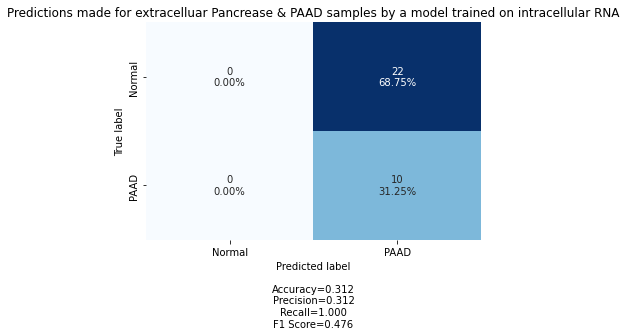

In [21]:
labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
# categories = ['Zero', 'One']
categories = ['Normal', 'PAAD']
#aedwip title =  "Extracellular Pancrease & PAAD. Intracellular PAAD 1vsAll biomarkers"
title = "Predictions made for extracelluar Pancrease & PAAD samples by a model trained on intracellular RNA"
fig, panel = make_confusion_matrix(confusion_matrix, 
                      # group_names=labels,
                      categories=categories, 
                      cbar=False,
                      count=True,
                      cmap='Blues',
                      title=title
                     )

In [ ]:
imgFilePL = imgOutPl.joinpath(NOTEBOOK_NAME + "-ConfusionMatrix.png")
fig.savefig(imgFilePL, dpi=600,  bbox_inches='tight', facecolor="white", transparent=True )